There is a lot of information on runners and their performance for the
Boston Marathon. Pick a year (post-2012 has more info) and do some
clustering.
Specifically, use the tools at hand to determine which clustering
solution, including number of clusters and algorithm used, is best for
the marathon data. Once you have a solution you like, write a data
story, including visualizations, where you teach the reader something
about the Boston Marathon based on your clusters. Write up your
report, including your process from start to finish. You must include
analysis as:
1. Draw bar graphs (both male & female in different color) for each
cluster for male and female, from the bar graphs, you can tell things
as which cluster contains the most number of female (or male).
2. Draw bar graphs for runners in different ranges of age (dividing by 3
groups: 18-25, 26-40, 40-70 or so) for each cluster (in different colors),
from the graph, you should be able to anwser which cluster contains
the most young people, which cluster contains oldest people, etc.
3. Do the same things as above for finishing time (which group runs fastest).

# Abstract
In this report, we will manipulate the data of Boston marathon runners in 2012 to do clustering. The technique used in this report is K-mean clustering algorithm, which is easy to implement and comprehend. This report will include:
1. Initial Data Exploration
2. Clustering
2. Data Visualization
4. Conclusion



## 1. Initial Data Exploration

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv('D:\\ML_coures\\CBD_assigment\\Assigment_06_KNN_clustering_Boston_marathon\\data\\results.csv')
## load data
pd.set_option('display.max_columns', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21652 entries, 0 to 21651
Data columns (total 12 columns):
division     21652 non-null object
name         21652 non-null object
city         21652 non-null object
gender       21652 non-null object
age          21652 non-null int64
official     21652 non-null object
bib          21652 non-null object
overall      21652 non-null object
state        19880 non-null object
genderdiv    21652 non-null object
net          21652 non-null float64
country      21652 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 2.0+ MB


In [3]:
print('Dataframe dimensions:', data.shape) ## print shape
pd.set_option('display.max_columns', None)
#____________________________________________________________
# gives some infor on columns types and number of null values
tab_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info



Dataframe dimensions: (21652, 12)


,division,name,city,gender,age,official,bib,overall,state,genderdiv,net,country
column type,object,object,object,object,int64,object,object,object,object,object,float64,object
null values,0,0,0,0,0,0,0,0,1772,0,0,0
null values (%),0,0,0,0,0,0,0,0,8.184,0,0,0


In [4]:
len(data.state.unique())

68

Let's drop the state column for ease in clustering due to its number of unique value is 68 and it is a category type variable. 

In [5]:
data=data.drop('state',axis=1)
data.head()

,division,name,city,gender,age,official,bib,overall,genderdiv,net,country
0,4 / 26,"Soejima, Masazumi",Fukuoka City,M,41,83.45,W1,4 / 35,4 / 26,83.45,JPN
1,14 / 4335,"Gebremariam, Gebregziabher",Tigray,M,27,142.93,2,14 / 21616,14 / 12621,142.93,ETH
2,6 / 26,"Van Dyk, Ernst F.",Paarl,M,39,84.38,W2,6 / 35,6 / 26,84.38,RSA
3,2 / 26,"Fearnley, Kurt H.",Hamilton,M,31,81.65,W3,2 / 35,2 / 26,81.65,AUS
4,3 / 26,"Hokinoue, Kota",Iizuka,M,38,83.43,W4,3 / 35,3 / 26,83.43,JPN


In [6]:
for col in data.columns:
    print ('Columns name',str(col),'           unique value: %5i'%len(data[col].unique()))
data.dtypes

Columns name division            unique value: 21652
Columns name name            unique value: 21621
Columns name city            unique value:  4975
Columns name gender            unique value:     2
Columns name age            unique value:    65
Columns name official            unique value:  9570
Columns name bib            unique value: 21652
Columns name overall            unique value: 21652
Columns name genderdiv            unique value: 21652
Columns name net            unique value:  9392
Columns name country            unique value:    60


division      object
name          object
city          object
gender        object
age            int64
official      object
bib           object
overall       object
genderdiv     object
net          float64
country       object
dtype: object

We have 21652 observations seperated into 11 features. We only use some of them to do analysis.



In [7]:
boston=data[['age','gender','official','country']]
boston.head()

,age,gender,official,country
0,41,M,83.45,JPN
1,27,M,142.93,ETH
2,39,M,84.38,RSA
3,31,M,81.65,AUS
4,38,M,83.43,JPN


In [8]:
# Changing the str columns float
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False
## just take data with usable value
for val, index in zip(boston.official,boston.official.index):
    if (isfloat(val)==False):
        boston=boston.drop(index)
boston.official= boston.official.astype(float) # convert to float
boston.info()

#boston

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21576 entries, 0 to 21651
Data columns (total 4 columns):
age         21576 non-null int64
gender      21576 non-null object
official    21576 non-null float64
country     21576 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 842.8+ KB


There are 76 unused values in the data and have been removed. Then we will encode for gender and country columns.

In [9]:
cat=['country']
for feature in cat:
    onehot = pd.get_dummies(boston[feature],drop_first=True)
    boston.drop(columns=feature, inplace=True)
    boston=boston.join(onehot)    



boston.gender=boston.gender.astype('category').cat.codes
#boston.country=boston.country.astype('category').cat.codes
boston.head()

,age,gender,official,AUS,AUT,BAH,BEL,BER,BRA,CAN,CAY,CHI,CHN,COL,CRC,CRO,CZE,DEN,DOM,ECU,ESP,EST,ETH,FIN,FRA,GBR,GER,GRE,GUA,HKG,HUN,IND,IRL,ISL,ISR,ITA,JPN,KEN,KOR,LUX,MAS,MEX,MLT,NED,NGR,NOR,NZL,PER,PHI,POL,POR,RSA,RUS,SIN,SLO,SUI,SVK,SWE,UAE,URU,USA,VEN
0,41,1,83.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,27,1,142.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39,1,84.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,31,1,81.65,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,38,1,83.43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2. Clustering using K-means

Now we will conduct the clustering, based on the elbow method we can select the optimium number of cluster as followed:

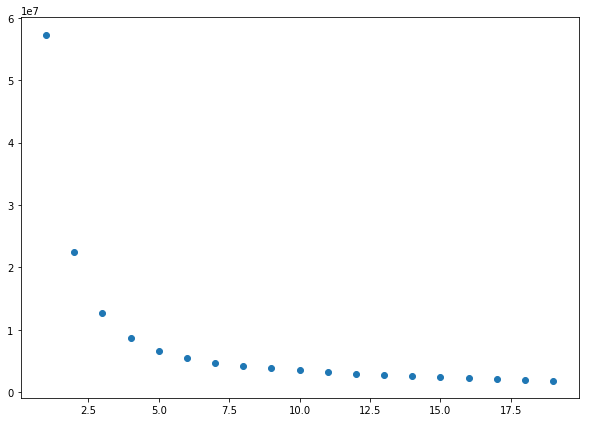

Text(3.1999999999999886, 0.5, 'Sum square variance')

In [10]:
#Scaling of data
ss = StandardScaler()
ss.fit_transform(boston)
var=[]
for k in range (1,20):
    kmeans=KMeans(n_clusters=k,algorithm='elkan', max_iter=100)
    kmeans.fit(boston)
    #labels = kmeans.predict(boston)
    centroids = kmeans.cluster_centers_
    ssvariance = kmeans.inertia_
    var.append(ssvariance)
fig = plt.figure(1, figsize=(10,7))
ax = fig.add_subplot(111)
num_k=range(1,20)
plt.scatter(num_k,var)
plt.show()
ax.set_title('Optimum elbow method for selecting # of cluster')
ax.set_xlabel('# cluster')
ax.set_ylabel('Sum square variance')

As shown in the elbow figure, the optimum number of cluster for this problem is 7. 
Thus:

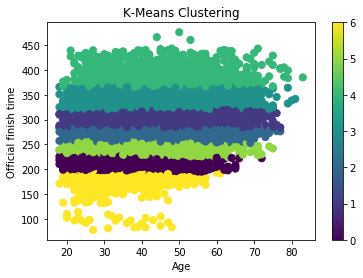

In [11]:
kmeans=KMeans(n_clusters=7,algorithm='elkan', max_iter=100)
kmeans.fit(boston)
labels = kmeans.predict(boston)
centers = kmeans.cluster_centers_
ssvariance = kmeans.inertia_
kmean_plot=pd.DataFrame(labels)
boston['kmeans']=kmean_plot
## plotting the clusters obtained using k mean
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(boston.age,boston.official,
                     c=kmean_plot[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Age')
ax.set_ylabel('Official finish time')
plt.colorbar(scatter)

Initially, we can see that group 7th (index 6) includes many young contestants which leads to the best perfomance in the finishing time. 

## 3. Visualization of clustering

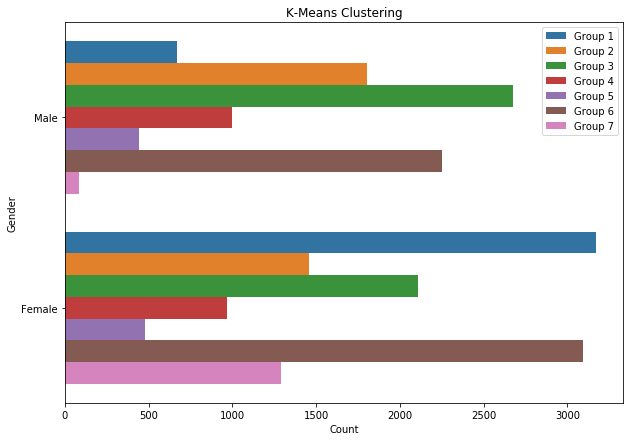

In [12]:
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y='gender', hue='kmeans', data=boston)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Count')
lab=['Male', 'Female']
ax.set_yticklabels(lab)
ax.set_ylabel('Gender')
# Set the legend
L = plt.legend()
for i in range (0,7):
    L.get_texts()[i].set_text('Group '+str(i+1))

As illustrated in the Figure, Group 6th has the largest number of contestants. Furthermore, the female ratio is dominant in this group. Generally, it is supprising that the female participants are usually more than the male in this year; however, in Group 2nd, the male participants are dominant.

In [13]:
#add columns for age div
age_group = lambda x: 0 if (x>18 and x<25) else(1 if (x>26 and x<40) else 2)
boston['age_group'] = boston.age.apply(age_group)
boston.head()


,age,gender,official,AUS,AUT,BAH,BEL,BER,BRA,CAN,CAY,CHI,CHN,COL,CRC,CRO,CZE,DEN,DOM,ECU,ESP,EST,ETH,FIN,FRA,GBR,GER,GRE,GUA,HKG,HUN,IND,IRL,ISL,ISR,ITA,JPN,KEN,KOR,LUX,MAS,MEX,MLT,NED,NGR,NOR,NZL,PER,PHI,POL,POR,RSA,RUS,SIN,SLO,SUI,SVK,SWE,UAE,URU,USA,VEN,kmeans,age_group
0,41,1,83.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,2
1,27,1,142.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1
2,39,1,84.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6.0,1
3,31,1,81.65,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1
4,38,1,83.43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1


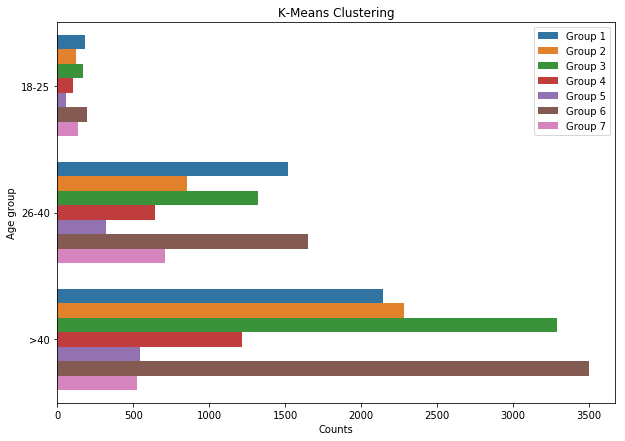

In [14]:
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y='age_group', hue='kmeans', data=boston)
ax.set_title('K-Means Clustering')
ax.set_ylabel('Age group')
ax.set_xlabel('Counts')

lab=['18-25', '26-40', '>40']
ax.set_yticklabels(lab)
# Set the legend
L = plt.legend()
for i in range (0,7):
    L.get_texts()[i].set_text('Group '+str(i+1))

The young group are the least compare the other contestants. In the group 6th, which has the most number of contestant, older people seems to participate more than the other. 

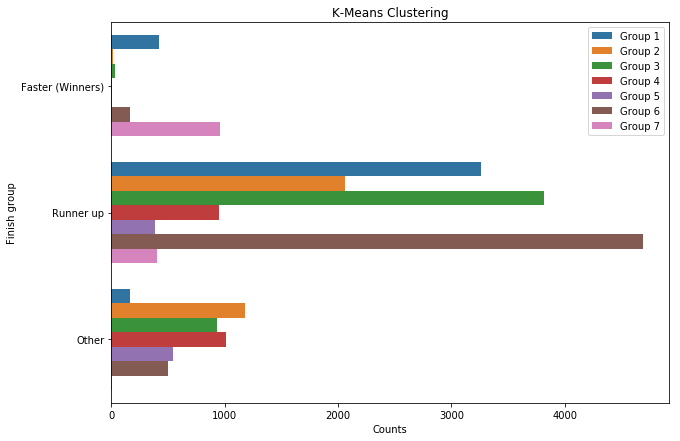

In [15]:
#add columns for age div
finish_group = lambda x: 0 if (x>60 and x<200) else(1 if (x>200 and x<300) else 2)
boston['finish_group'] = boston.official.apply(finish_group)
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y='finish_group', hue='kmeans', data=boston)
ax.set_title('K-Means Clustering')
ax.set_ylabel('Finish group')
ax.set_xlabel('Counts')

lab=['Faster (Winners)', 'Runner up', 'Other']
ax.set_yticklabels(lab)
# Set the legend
L = plt.legend()
for i in range (0,7):
    L.get_texts()[i].set_text('Group '+str(i+1))

In [16]:
check=boston[['kmeans','official']]
for k in range(0,7):
    dt=check.loc[check.kmeans==k]
    print('Mean time of group %5i : %12.5f'%(k+1,dt.official.mean()))

Mean time of group     1 :    232.42246
Mean time of group     2 :    290.61385
Mean time of group     3 :    271.52882
Mean time of group     4 :    306.31611
Mean time of group     5 :    315.16944
Mean time of group     6 :    252.22000
Mean time of group     7 :    192.22652


As expected, Group 7th run the fastest with mean finish time is 192 seconds. Amazingly, group 1st has many contestants who finish at runner up place.

## 4. Conclusion

In this report, the data for Boston marathon contestant in 2012 is used and clustered by K-means clustering algorithm (for a dense matrix). After clustering, using the elbow method, the data is divided into 7 groups based on 4 features: Age, Gender, Country and Official Finish time. As a result, Group 7th run the fastest with mean finish time is 192 seconds. Amazingly, group 1st has many contestants who finish at runner up place. Furthermore, the young group are the least compare the other contestants. In the group 6th, which has the most number of contestant, older people seems to participate more than the other. Generally, it is suppuring that the female participants are usually more than the male in this year; however, in Group 2nd, the male participants are dominant.